In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import json

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('/home/jko/ice3d')
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from data.single_view_dataset import SingleViewDataset
from data.single_view_datamodule import SingleViewDataModule
from models.cnn_regression import VanillaCNNRegression
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

In [4]:
# set parameters
n_rand = 666 # random seed
lr = 1e-3
num_epochs = 20
batch_size = 32
# Load the class mapping from a JSON file
class_mapping_file = '/home/jko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms
# # set indices of train/val/test sets
split = [0.7, 0.15, 0.15]
n_data = 700_000
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used
train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))

# # random split of train/val/test 
# indices = list(range(n_data))
# # First split: train vs (val + test)
# train_idx, temp_idx = train_test_split(
#     indices, test_size=0.3, random_state=n_rand
# )
# # Second split: val vs test (50% of 30% => 15% each)
# val_idx, test_idx = train_test_split(
#     temp_idx, test_size=0.5, random_state=n_rand
# )
# # Confirm sizes
# print(f"Train: {len(train_idx)}")  # ~490,000
# print(f"Val: {len(val_idx)}")      # ~105,000
# print(f"Test: {len(test_idx)}")    # ~105,000

# define log transform for later
def log_transform(x):
    return torch.log(x)

In [5]:
def get_transforms(data_type, input_channels, task_type):
    transforms = {}
    # Define transforms based on data_type
    if data_type in ['single_view_h5', 'stereo_view_h5']:
        train_transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        val_transform = T.Compose([
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        transforms['train'] = train_transform
        transforms['val'] = val_transform
        transforms['test'] = val_transform
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['train_target'] = target_transform
        transforms['val_target'] = target_transform
        transforms['test_target'] = target_transform    
        return transforms
    elif data_type == 'tabular':
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['target'] = target_transform
        return transforms
    else:
        return None

# 1\) Single view (default)

In [6]:
data_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
data_file = 'default_shuffled_small.h5'
data_path = os.path.join(data_dir, data_file)

## a) Regression

In [7]:
targets = ['rho_eff', 'sa_eff']
data_type = 'single_view_h5'
input_channels = 1
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)
dm = SingleViewDataModule(
    hdf_file=data_path,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='regression',
    class_to_idx=None
)
dm.setup()

In [45]:
# instantiate model
input_channels = 1 
output_size = len(targets)
model = VanillaCNNRegression(
    input_channels=input_channels, 
    output_size=output_size, 
    learning_rate=lr)
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'cnn-regression-subset-70k-tb'
csv_log_name = f'cnn-regression-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

In [46]:
# Set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)
# Train the model
trainer.fit(model, dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 160    | train
1 | conv2 | Conv2d    | 4.6 K  | train
2 | conv3 | Conv2d    | 18.5 K | train
3 | pool  | MaxPool2d | 0      | train
4 | fc1   | Linear    | 6.4 M  | train
5 | fc2   | Linear    | 8.3 K  | train
6 | fc3   | Linear    | 130    | train
--------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.817    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 9:  95%|█████████▌| 14617/15312 [07:24<00:21, 32.85it/s, v_num=5]    

Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


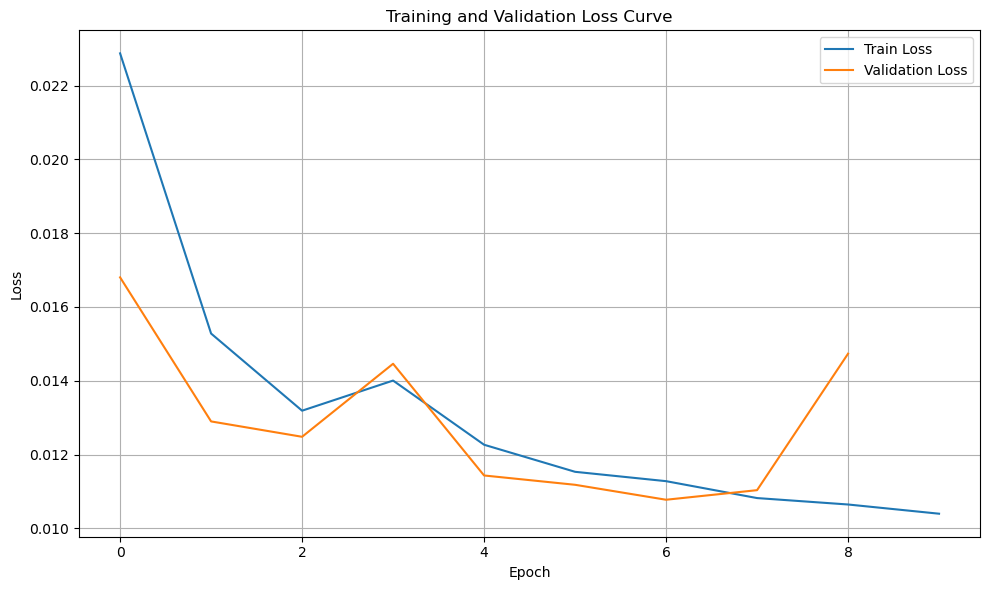

In [3]:
# plot loss curve
log_path = '/home/jko/ice3d/models/lightning_logs/cnn-regression-subset-70k-csv/version_5/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
metrics = pd.read_csv('/home/jko/ice3d/models/lightning_logs/cnn-regression-subset-70k-csv/version_1/metrics.csv')
metrics.head()


In [ ]:
metrics[metrics.epoch==3]

# TEST: eval model with ckpt

In [9]:
# load model from checkpoint
model_ckpt = '/home/jko/ice3d/models/lightning_logs/cnn-regression-subset-70k-csv/version_5/checkpoints/epoch=9-step=153120.ckpt'
model = VanillaCNNRegression.load_from_checkpoint(
    model_ckpt,
    input_channels=1, 
    output_size=2, 
    learning_rate=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

VanillaCNNRegression(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

Processing batch 1 out of 3282...
Processing batch 2 out of 3282...
Processing batch 3 out of 3282...
Processing batch 4 out of 3282...
Processing batch 5 out of 3282...
Processing batch 6 out of 3282...
Processing batch 7 out of 3282...
Processing batch 8 out of 3282...
Processing batch 9 out of 3282...
Processing batch 10 out of 3282...
R² for rho_eff: 0.97
R² for sa_eff: 0.95


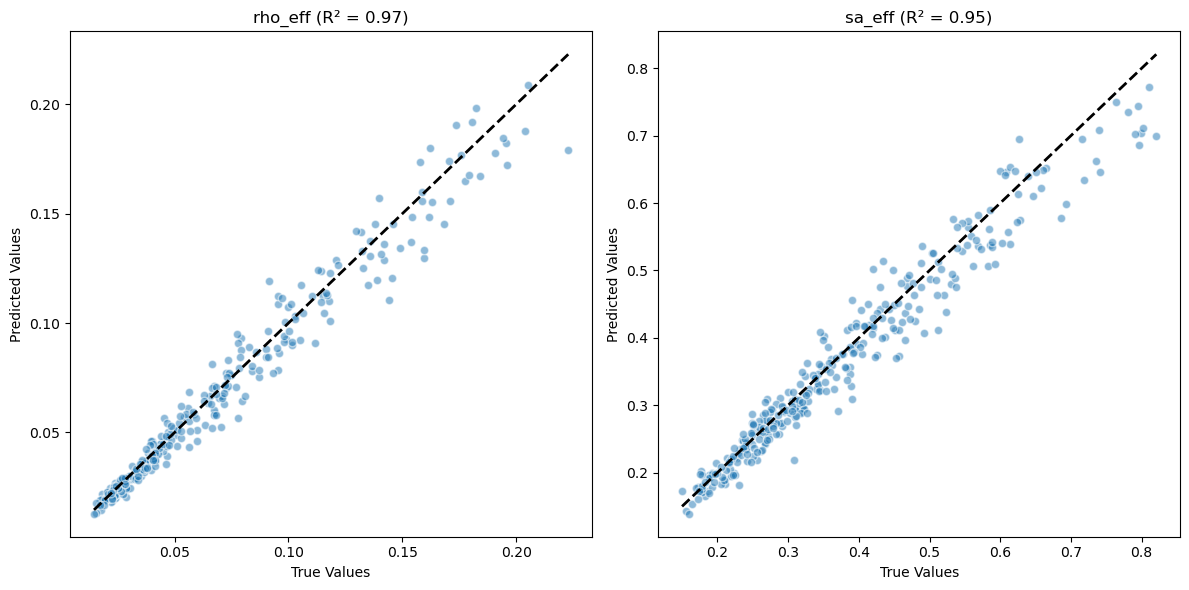

In [10]:
# Get test data
loader = dm.val_dataloader()
all_preds = []
all_targets = []
n_batches = 10  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

### Check hdf data

In [ ]:
import h5py
with h5py.File(data_path, 'r') as f:
    print("Keys: %s" % list(f.keys()))
    imgs = f['images'] 
    imgs_np = imgs[:]
imgs_np.shape

In [ ]:
# val set 
val_idx_np = np.array(val_idx)
print(val_idx_np.min(), val_idx_np.max())
print(f'n_val = {len(val_idx_np)}')

In [ ]:
N = imgs_np.shape[0]
chunk_size = 100

start = val_idx_np.min()
end = val_idx_np.max() - chunk_size + 1
# Pick a valid starting index (so that start + 100 <= N)
start_idx = np.random.randint(start, end)

# Extract the contiguous chunk
chunk = imgs_np[start_idx:start_idx + chunk_size]

fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(chunk[i], cmap='gray_r')
    ax.axis('off')  # Hide axis and ticks

plt.tight_layout(pad=0)
plt.show()

In [ ]:
# val set 
val_idx_np = np.array(val_idx)
print(val_idx_np.min(), val_idx_np.max())
print(f'n_val = {len(val_idx_np)}')